In [38]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt

In [39]:
def pulse_rect(sps, t_sym, rect_width=-1):
    if rect_width==-1 or rect_width==t_sym:
        return np.ones(sps)
    n_ones = int((rect_width/t_sym)*sps)
    n_zeros = int((sps-n_ones)/2)
    #TODO: make this always return a signal with size=sps
    assert sps == n_ones + n_zeros + n_zeros
    return np.hstack((np.zeros(n_zeros), np.ones(n_ones), np.zeros(n_zeros)))

def apply_pulse_shape(data_symbols:np.array, pulse_signal:np.array, flatten=False)->np.array:
    """ Generate pulse shaped data array.
       
        Positional Arguments:
            data_symbols: set of data symbols to be shaped.
            pulse_signal: The pulse waveform that does the shaping.
            flatten: T/F, if true then the returned data will be a row vector with shape (1, n_sym*sps).
                          if false then the returned data will be a matrix where each row is a pulse-shaped symbol. dim -> (n_sym, sps)
            
    """
    n_sym = len(data_symbols)
    sps = len(pulse_signal)
    data = np.multiply(data_symbols.reshape(n_sym, 1), pulse_signal.reshape(1, sps))
    if flatten:
        return data.reshape(int(n_sym*sps),)
    else:
        return data 

In [41]:
#Constants
N_FFT = 64
N_CP = 16
N_GI = 32
N_BLOCKS = 10

#import given data
ofdm_pkt = spio.loadmat('./ofdm_pkt.mat')
s = ofdm_pkt['s']
y = ofdm_pkt['y']

In [48]:
message = 'hello world'


(1, 52)

In [80]:
message = 'hello'
data = message.encode('utf-8')
data_bits = np.unpackbits(np.frombuffer(data, dtype=np.uint8))
data_bits.dtype = np.int8
data_bits = 2*data_bits - 1
data_bits

array([-1,  1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1,
        1,  1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1, -1,  1,
        1, -1,  1,  1,  1,  1], dtype=int8)

In [83]:
def bits_to_qpsk(bits: np.ndarray) -> np.ndarray:
    # Ensure we have an even number of bits by padding if necessary
    if len(bits) % 2 != 0:
        bits = np.append(bits, 0)
    bit_pairs = bits.reshape(-1, 2)
    print(bit_pairs)
    indices = bit_pairs[:, 0] * 2 + bit_pairs[:, 1]
    print(indices)
    qpsk_map = np.array([1+1j, -1+1j, 1-1j, -1-1j])
    qpsk_symbols = qpsk_map[indices]
    return qpsk_symbols

In [84]:
data_symbols = bits_to_qpsk(data_bits)

[[-1  1]
 [ 1 -1]
 [ 1 -1]
 [-1 -1]
 [-1  1]
 [ 1 -1]
 [-1  1]
 [-1  1]
 [-1  1]
 [ 1 -1]
 [ 1  1]
 [-1 -1]
 [-1  1]
 [ 1 -1]
 [ 1  1]
 [-1 -1]
 [-1  1]
 [ 1 -1]
 [ 1  1]
 [ 1  1]]
[-1  1  1 -3 -1  1 -1 -1 -1  1  3 -3 -1  1  3 -3 -1  1  3  3]


In [78]:
print(len(data_bits))
print(len(data_symbols))

88
44


In [87]:
def bits_to_symbols(bits: np.ndarray, symbol_alphabet: np.ndarray) -> np.ndarray:
    """
    Convert an array of bits to symbols using a custom alphabet.
    
    Parameters:
    -----------
    bits : np.ndarray
        Array of bits (0s and 1s)
    symbol_alphabet : np.ndarray
        Array of complex symbols to use as the alphabet.
        The length must be a power of 2.
    
    Returns:
    --------
    np.ndarray
        Array of complex symbols
    """
    n_symbols = len(symbol_alphabet)
    assert n_symbols & (n_symbols - 1) == 0, 'Symbol alphabet length must be a power of 2'
    bits_per_symbol = int(np.log2(n_symbols))
    remainder = len(bits) % bits_per_symbol
    if remainder != 0:
        pad_length = bits_per_symbol - remainder
        bits = np.append(bits, np.zeros(pad_length, dtype=bits.dtype))
    bit_groups = bits.reshape(-1, bits_per_symbol)
    powers = 2 ** np.arange(bits_per_symbol - 1, -1, -1)
    indices = np.sum(bit_groups * powers, axis=1).astype(int)
    symbols = symbol_alphabet[indices]
    return symbols

In [88]:
x = bits_to_symbols(data_bits, [1+1j, 1-1j, -1+1j, -1-1j])

TypeError: only integer scalar arrays can be converted to a scalar index

In [89]:
import numpy as np

def get_str_as_bits(s: str, encode: str = 'utf-8') -> np.ndarray:
    """
    Convert a string to a numpy array of bits (0s and 1s).
    
    Parameters:
    -----------
    s : str
        The input string to convert
    encode : str, optional
        The encoding to use, by default 'utf-8'
    
    Returns:
    --------
    np.ndarray
        A 1D numpy array containing the binary representation (0s and 1s)
    """
    # Convert string to bytes using the specified encoding
    byte_data = s.encode(encode)
    
    # Convert bytes to uint8 array
    uint8_array = np.frombuffer(byte_data, dtype=np.uint8)
    
    # Unpack uint8 array to bits
    bit_array = np.unpackbits(uint8_array)
    
    return bit_array

def bits_to_symbols(bits: np.ndarray, symbol_alphabet: np.ndarray) -> np.ndarray:
    """
    Convert an array of bits to symbols using a custom alphabet.
    
    Parameters:
    -----------
    bits : np.ndarray
        Array of bits (0s and 1s)
    symbol_alphabet : np.ndarray
        Array of complex symbols to use as the alphabet.
        The length must be a power of 2.
    
    Returns:
    --------
    np.ndarray
        Array of complex symbols
    """
    # Verify that symbol_alphabet length is a power of 2
    n_symbols = len(symbol_alphabet)
    if n_symbols & (n_symbols - 1) != 0:
        raise ValueError("Symbol alphabet length must be a power of 2")
    
    # Calculate how many bits per symbol
    bits_per_symbol = int(np.log2(n_symbols))
    
    # Pad bits if necessary to make it divisible by bits_per_symbol
    remainder = len(bits) % bits_per_symbol
    if remainder != 0:
        pad_length = bits_per_symbol - remainder
        bits = np.append(bits, np.zeros(pad_length, dtype=bits.dtype))
    
    # Reshape bits into groups
    bit_groups = bits.reshape(-1, bits_per_symbol)
    
    # Convert bit groups to indices (binary to decimal conversion)
    powers = 2 ** np.arange(bits_per_symbol - 1, -1, -1)
    indices = np.sum(bit_groups * powers, axis=1).astype(int)
    
    # Map indices to symbols
    symbols = symbol_alphabet[indices]
    
    return symbols

def str_to_symbols(s: str, symbol_alphabet: np.ndarray, encode: str = 'utf-8') -> np.ndarray:
    """
    Convert a string directly to symbols using a custom alphabet.
    
    Parameters:
    -----------
    s : str
        The input string to convert
    symbol_alphabet : np.ndarray
        Array of complex symbols to use as the alphabet.
        The length must be a power of 2.
    encode : str, optional
        The encoding to use, by default 'utf-8'
    
    Returns:
    --------
    np.ndarray
        Array of complex symbols
    """
    bits = get_str_as_bits(s, encode)
    return bits_to_symbols(bits, symbol_alphabet)

# Example usages:

# QPSK alphabet (same as before)
qpsk_alphabet = np.array([1+1j, -1+1j, -1-1j, 1-1j])

# 8-PSK alphabet example
psk8_alphabet = np.exp(1j * np.arange(0, 2*np.pi, 2*np.pi/8))

# 16-QAM alphabet example
def create_qam16_alphabet():
    """Create a 16-QAM constellation."""
    real_parts = np.array([-3, -1, 1, 3])
    imag_parts = np.array([-3, -1, 1, 3])
    real_grid, imag_grid = np.meshgrid(real_parts, imag_parts)
    return (real_grid.flatten() + 1j * imag_grid.flatten()) / np.sqrt(10)  # Normalized

# 64-QAM alphabet example
def create_qam64_alphabet():
    """Create a 64-QAM constellation."""
    real_parts = np.array([-7, -5, -3, -1, 1, 3, 5, 7])
    imag_parts = np.array([-7, -5, -3, -1, 1, 3, 5, 7])
    real_grid, imag_grid = np.meshgrid(real_parts, imag_parts)
    return (real_grid.flatten() + 1j * imag_grid.flatten()) / np.sqrt(42)  # Normalized

In [90]:
# Example with QPSK (4 symbols = 2 bits per symbol)
qpsk_alphabet = np.array([1+1j, -1+1j, -1-1j, 1-1j])
qpsk_symbols = str_to_symbols("hello", qpsk_alphabet)

# Example with 8-PSK (8 symbols = 3 bits per symbol)
psk8_alphabet = np.exp(1j * np.arange(0, 2*np.pi, 2*np.pi/8))
psk8_symbols = str_to_symbols("hello", psk8_alphabet)

# Example with 16-QAM (16 symbols = 4 bits per symbol)
qam16_alphabet = create_qam16_alphabet()
qam16_symbols = str_to_symbols("hello", qam16_alphabet)

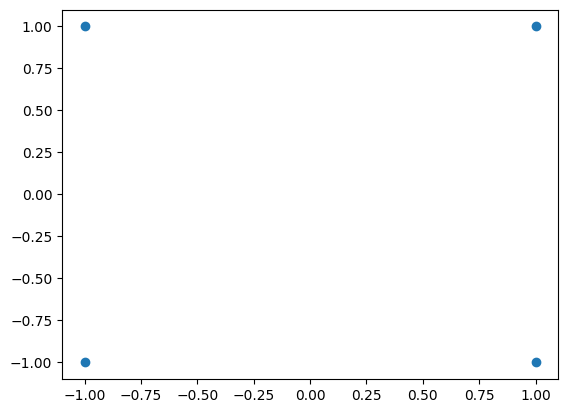

In [97]:
plt.scatter(qpsk_alphabet.real, qpsk_alphabet.imag)

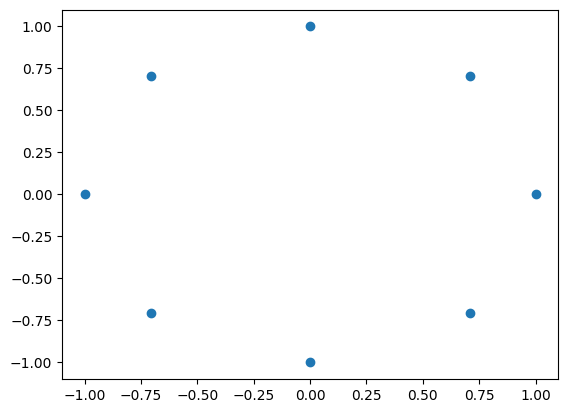

In [99]:
plt.scatter(psk8_alphabet.real, psk8_alphabet.imag)

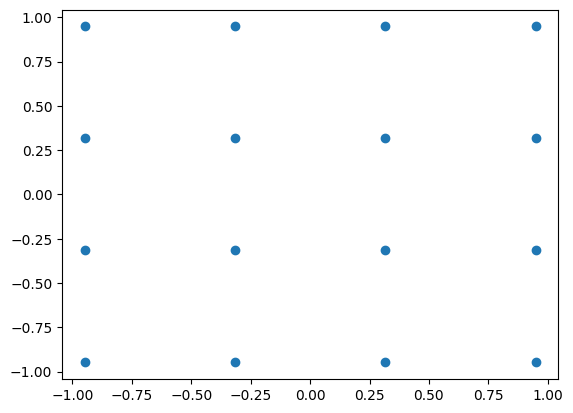

In [100]:
plt.scatter(qam16_alphabet.real, qam16_alphabet.imag)